# TFG

Primero importamos las librerías

In [1]:
import pandas as pd
import numpy as np

Importamos los datos, e imprimimos los primeros para comprobar que se han importado correctamente.

In [2]:
df = pd.read_csv('BTC-Daily.csv')
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,49.006289,2.116360e+06
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3160.618070,1.364723e+08
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1701.817043,6.418008e+07
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,912.724087,3.573010e+07
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2202.851827,8.642149e+07


Imprimimos la información de cada característica

In [3]:
df.tail()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
2646,1417478400,2014-12-02 00:00:00,BTC/USD,378.39,382.86,375.23,379.25,2593576.46,6832.53
2647,1417392000,2014-12-01 00:00:00,BTC/USD,376.40,382.31,373.03,378.39,2520662.37,6660.56
2648,1417305600,2014-11-30 00:00:00,BTC/USD,376.57,381.99,373.32,373.34,1145566.61,3046.33
2649,1417219200,2014-11-29 00:00:00,BTC/USD,376.42,386.60,372.25,376.72,2746157.05,7245.19
2650,1417132800,2014-11-28 00:00:00,BTC/USD,363.59,381.34,360.57,376.28,3220878.18,8617.15


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unix        2651 non-null   int64  
 1   date        2651 non-null   object 
 2   symbol      2651 non-null   object 
 3   open        2651 non-null   float64
 4   high        2651 non-null   float64
 5   low         2651 non-null   float64
 6   close       2651 non-null   float64
 7   Volume BTC  2651 non-null   float64
 8   Volume USD  2651 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 186.5+ KB
None


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unix,2651.0,1.531613e+09,6.613247e+07,1.417133e+09,1.474373e+09,1.531613e+09,1.588853e+09,1.646093e+09
open,2651.0,1.169319e+04,1.627255e+04,1.620000e+02,6.546800e+02,6.408950e+03,1.070862e+04,6.754749e+04
high,2651.0,1.203856e+04,1.673924e+04,2.128400e+02,6.644600e+02,6.540000e+03,1.095624e+04,6.900000e+04
low,2651.0,1.129654e+04,1.571830e+04,1.524000e+02,6.400500e+02,6.312000e+03,1.030376e+04,6.625000e+04
close,2651.0,1.170933e+04,1.628291e+04,1.620000e+02,6.543700e+02,6.407770e+03,1.072642e+04,6.755900e+04
Volume BTC,2651.0,1.330041e+07,4.715366e+07,0.000000e+00,5.357883e+03,1.503310e+04,3.435336e+06,7.723295e+08
Volume USD,2651.0,6.099369e+07,1.072838e+08,0.000000e+00,9.516170e+03,2.288982e+07,8.018383e+07,1.446125e+09


array([[<Axes: title={'center': 'open'}>]], dtype=object)

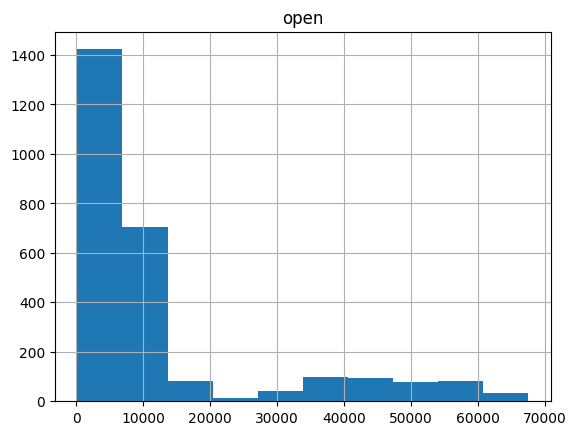

In [7]:
df.hist('open')

In [9]:
df.sort_values(by='close')

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
2603,1421193600,2015-01-14 00:00:00,BTC/USD,221.00,230.89,152.40,162.00,2.364766e+07,1.235998e+05
2600,1421452800,2015-01-17 00:00:00,BTC/USD,206.60,212.84,192.17,200.10,4.007436e+06,1.993378e+04
2601,1421366400,2015-01-16 00:00:00,BTC/USD,214.77,223.15,198.04,206.60,7.308110e+06,3.465709e+04
2602,1421280000,2015-01-15 00:00:00,BTC/USD,162.00,233.90,161.10,208.81,1.772132e+07,8.615817e+04
2597,1421712000,2015-01-20 00:00:00,BTC/USD,217.84,217.84,201.98,211.08,2.998319e+06,1.423473e+04
...,...,...,...,...,...,...,...,...,...
111,1636502400,2021-11-10 00:00:00,BTC/USD,66928.42,69000.00,62856.71,64921.43,3.419119e+03,2.219741e+08
107,1636848000,2021-11-14 00:00:00,BTC/USD,64403.43,65509.87,63595.76,65509.87,1.247885e+03,8.174875e+07
132,1634688000,2021-10-20 00:00:00,BTC/USD,64282.20,67016.50,63529.00,65990.31,3.070684e+03,2.026354e+08
112,1636416000,2021-11-09 00:00:00,BTC/USD,67547.49,68564.40,66250.00,66945.72,2.136858e+03,1.430535e+08


In [8]:
df.sort_values(by='date')

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
2650,1417132800,2014-11-28 00:00:00,BTC/USD,363.59,381.34,360.57,376.28,3.220878e+06,8.617150e+03
2649,1417219200,2014-11-29 00:00:00,BTC/USD,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03
2648,1417305600,2014-11-30 00:00:00,BTC/USD,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
2647,1417392000,2014-12-01 00:00:00,BTC/USD,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
2646,1417478400,2014-12-02 00:00:00,BTC/USD,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
...,...,...,...,...,...,...,...,...,...
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2.202852e+03,8.642149e+07
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,9.127241e+02,3.573010e+07
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1.701817e+03,6.418008e+07
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3.160618e+03,1.364723e+08


In [12]:
df_sin_unix = df.copy().drop(['unix'], axis = 1)
df_sin_unix.sort_values(by = 'date')

,date,symbol,open,high,low,close,Volume BTC,Volume USD
2650,2014-11-28 00:00:00,BTC/USD,363.59,381.34,360.57,376.28,3.220878e+06,8.617150e+03
2649,2014-11-29 00:00:00,BTC/USD,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03
2648,2014-11-30 00:00:00,BTC/USD,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
2647,2014-12-01 00:00:00,BTC/USD,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
2646,2014-12-02 00:00:00,BTC/USD,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
...,...,...,...,...,...,...,...,...
4,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2.202852e+03,8.642149e+07
3,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,9.127241e+02,3.573010e+07
2,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1.701817e+03,6.418008e+07
1,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3.160618e+03,1.364723e+08


In [15]:
#df_sn = solo los datos necesarios para entrenar el algoritmo, con tiempo aún de reducirlos más
df_sn = df.copy().drop(['unix', 'symbol', 'Volume BTC'], axis = 1)
df_sn.sort_values(by='date')

,date,open,high,low,close,Volume USD
2650,2014-11-28 00:00:00,363.59,381.34,360.57,376.28,8.617150e+03
2649,2014-11-29 00:00:00,376.42,386.60,372.25,376.72,7.245190e+03
2648,2014-11-30 00:00:00,376.57,381.99,373.32,373.34,3.046330e+03
2647,2014-12-01 00:00:00,376.40,382.31,373.03,378.39,6.660560e+03
2646,2014-12-02 00:00:00,378.39,382.86,375.23,379.25,6.832530e+03
...,...,...,...,...,...,...
4,2022-02-25 00:00:00,38360.93,39727.97,38027.61,39231.64,8.642149e+07
3,2022-02-26 00:00:00,39242.64,40330.99,38600.00,39146.66,3.573010e+07
2,2022-02-27 00:00:00,39146.66,39886.92,37015.74,37712.68,6.418008e+07
1,2022-02-28 00:00:00,37717.10,44256.08,37468.99,43178.98,1.364723e+08
